# **Week 4 Assignment: Saliency Maps**

Welcome to the final programming exercise of this course! For this week, your task is to adapt the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) Class Activation Map ungraded lab (the second ungraded lab of this week) and make it generate saliency maps instead.

As discussed in the lectures, a saliency map shows the pixels which greatly impacts the classification of an image.
- This is done by getting the gradient of the loss with respect to changes in the pixel values, then plotting the results.
- From there, you can see if your model is looking at the correct features when classifying an image.
  - For example, if you're building a dog breed classifier, you should be wary if your saliency map shows strong pixels outside the dog itself (e.g. sky, grass, dog house, etc...).

In this assignment you will be given prompts but less starter code to fill in in.
- It's good practice for you to try and write as much of this code as you can from memory and from searching the web.
- **Whenever you feel stuck**, please refer back to the labs of this week to see how to write the code. In particular, look at:
  - **Ungraded Lab 2: Cats vs Dogs CAM**
  - **Ungraded Lab 3: Saliency**




### Download test files and weights

Let's begin by first downloading files we will be using for this lab.

In [1]:
# Download the same test files from the Cats vs Dogs ungraded lab
!wget -O cat1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
!wget -O cat2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
!wget -O catanddog.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/catanddog.jpeg
!wget -O dog1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog1.jpeg
!wget -O dog2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog2.jpeg

# Download prepared weights
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kipXTxesGJKGY1B8uSPRvxROgOH90fih' -O 0_epochs.h5
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1oiV6tjy5k7h9OHGTQaf0Ohn3FmF-uOs1' -O 15_epochs.h5


--2025-07-31 04:43:17--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.207, 64.233.179.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K  --.-KB/s    in 0.004s  

2025-07-31 04:43:17 (93.7 MB/s) - ‘cat1.jpg’ saved [414826/414826]

--2025-07-31 04:43:18--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.183.207, 172.217.214.207, 74.125.132.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.183.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Savi

### Import the required packages

Please import:

  * Tensorflow
  * Tensorflow Datasets
  * Numpy
  * Matplotlib's PyPlot
  * Keras Models API classes you will be using
  * Keras layers you will be using
  * OpenCV (cv2)

In [2]:
# YOUR CODE HERE
import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
import cv2

2025-07-31 04:43:23.980884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753937004.224736      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753937004.295917      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Download and prepare the dataset.



#### Load Cats vs Dogs

* Required: Use Tensorflow Datasets to fetch the `cats_vs_dogs` dataset.
  * Use the first 80% of the *train* split of the said dataset to create your training set.
  * Set the `as_supervised` flag to create `(image, label)` pairs.
    
* Optional: You can create validation and test sets from the remaining 20% of the *train* split of `cats_vs_dogs` (i.e. you already used 80% for the train set). This is if you intend to train the model beyond what is required for submission.

In [3]:
# Load the data and create the train set (optional: val and test sets)

# YOUR CODE HERE

# Load cats_vs_dogs dataset
dataset, info = tfds.load('cats_vs_dogs', split='train', as_supervised=True, with_info=True) # No subset is specified, so you get all the training examples (100%) available in the dataset.

# get the total number of examples
total_examples = info.splits['train'].num_examples

# Calculate sizes of train, avlidation, and test sets
train_size = int(0.8 * total_examples)
val_size = int(0.1 * total_examples)
test_size = total_examples - train_size - val_size

# Split the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# Optional: Print dataset sizes to verify
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

I0000 00:00:1753937028.593291      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753937028.594047      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 ext

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.MAZIKX_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Training set size: 18609
Validation set size: 2326
Test set size: 2327


#### Create preprocessing function

Define a function that takes in an image and label. This will:
  * cast the image to float32
  * normalize the pixel values to [0, 1]
  * resize the image to 300 x 300


In [4]:
def augmentimages(image, label):
  # YOUR CODE HERE
  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label

#### Preprocess the training set

Use the `map()` and pass in the method that you just defined to preprocess the training set.


In [5]:
# YOUR CODE HERE
# use the utility function above to preprocess the images
# augmented_training_data = dataset.map(augmentimages)
training_batches = train_dataset.map(augmentimages).batch(32).prefetch(tf.data.AUTOTUNE)
val_batches = val_dataset.map(augmentimages).batch(32).prefetch(tf.data.AUTOTUNE)
test_batches = test_dataset.map(augmentimages).batch(32).prefetch(tf.data.AUTOTUNE)

print(f"Validation batches: {len(list(val_batches))}")


Validation batches: 73


#### Create batches of the training set.

This is already provided for you. Normally, you will want to shuffle the training set. But for predictability in the grading, we will simply create the batches.

```Python
# Shuffle the data if you're working on your own personal project
train_batches = augmented_training_data.shuffle(1024).batch(32)
```

In [6]:
# train_batches = augmented_training_data.batch(32)

### Build the Cats vs Dogs classifier

You'll define a model that is nearly the same as the one in the Cats vs. Dogs CAM lab.
* Please preserve the architecture of the model in the Cats vs Dogs CAM lab (this week's second lab) except for the final `Dense` layer.
* You should modify the Cats vs Dogs model at the last dense layer to output 2 neurons instead of 1.
  - This is because you will adapt the `do_salience()` function from the lab and that works with one-hot encoded labels.
  - You can do this by changing the `units` argument of the output Dense layer from 1 to 2, with one for each of the classes (i.e. cats and dogs).
  - You should choose an activation that outputs a probability for each of the 2 classes (i.e. categories), where the sum of the probabilities adds up to 1.

In [7]:
# YOUR CODE HERE
model = Sequential()

model.add(keras.Input(shape=(300,300,3)))
model.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 300, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,698 (381.63 KB)

 Trainable params: 97,698 (381.63 KB)

 Non-trainable params: 0 (0.00 B)

**Expected Output:**

```txt
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
=================================================================
Total params: 97,698
Trainable params: 97,698
Non-trainable params: 0
_________________________________________________________________
```

### Create a function to generate the saliency map

Complete the `do_salience()` function below to save the **normalized_tensor** image.
- The major steps are listed as comments below.
  - Each section may involve multiple lines of code.
- Try your best to write the code from memory or by performing web searches.
  - Whenever you get stuck, you can review the "saliency" lab (the third lab of this week) to help remind you of what code to write

In [8]:
def do_salience(image, model, label, prefix):

  '''
  Generates the saliency map of a given image.

  Args:
    image (file) -- picture that the model will classify
    model (keras Model) -- your cats and dogs classifier
    label (int) -- ground truth label of the image
    prefix (string) -- prefix to add to the filename of the saliency map
  '''

  # Read the image and convert channel order from BGR to RGB
  # YOUR CODE HERE

  # read the image
  img = cv2.imread(image)
  # format it to be in the RGB colorspace
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Resize the image to 300 x 300 and normalize pixel values to the range [0, 1]
  # YOUR CODE HERE
  # resize to 300x300 and normalize pixel values to be in the range [0, 1]
  img = cv2.resize(img, (300, 300)) / 255.0

  # Add an additional dimension (for the batch), and save this in a new variable
  # YOUR CODE HERE
  # add a batch dimension in front
  image_tensor = tf.convert_to_tensor(np.expand_dims(img, axis=0), dtype=tf.float32)

  # Declare the number of classes
  # YOUR CODE HERE
  # number of classes in the model's training data
  num_classes = 2

  # Define the expected output array by one-hot encoding the label
  # The length of the array is equal to the number of classes
  # YOUR CODE HERE
  # convert to one hot representation to match our softmax activation in the model definition
  # dummy one-hot encoded label (you can set the index depending on the class)
  expected_output = tf.convert_to_tensor([[0.0, 1.0]])

  # Witin the GradientTape block:
  # Cast the image as a tf.float32
  # Use the tape to watch the float32 image
  # Get the model's prediction by passing in the float32 image
  # Compute an appropriate loss
  # between the expected output and model predictions.
  # you may want to print the predictions to see if the probabilities adds up to 1
  # YOUR CODE HERE
  with tf.GradientTape() as tape:

    # cast image to float
    inputs = tf.cast(image_tensor, tf.float32)

    # watch the input pixels
    tape.watch(inputs)

    # generate the predictions
    predictions = model(inputs)

    # get the loss
    loss = tf.keras.losses.categorical_crossentropy(expected_output, predictions)

  # get the gradients of the loss with respect to the model's input image
  # YOUR CODE HERE
  gradients = tape.gradient(loss, inputs)

  # generate the grayscale tensor
  # YOUR CODE HERE
  # reduce the RGB image to grayscale
  grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

  # normalize the pixel values to be in the range [0, 255].
  # the max value in the grayscale tensor will be pushed to 255.
  # the min value will be pushed to 0.
  # Use the formula: 255 * (x - min) / (max - min)
  # Use tf.reduce_max, tf.reduce_min
  # Cast the tensor as a tf.uint8
  # YOUR CODE HERE
  normalized_tensor = tf.cast(255 * (grayscale_tensor - tf.reduce_min(grayscale_tensor)) / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)), tf.uint8,)

  # Remove dimensions that are size 1
  # YOUR CODE HERE
  # remove the channel dimension to make the tensor a 2d tensor
  normalized_tensor = tf.squeeze(normalized_tensor)

  # plot the normalized tensor
  # Set the figure size to 8 by 8
  # do not display the axis
  # use the 'gray' colormap
  # This code is provided for you.
  plt.figure(figsize=(8, 8))
  plt.axis('off')
  plt.imshow(normalized_tensor, cmap='gray')
  plt.show()

  # optional: superimpose the saliency map with the original image, then display it.
  # we encourage you to do this to visualize your results better
  # YOUR CODE HERE
  plt.figure(figsize=(8, 8))
  plt.axis('off')
  plt.imshow(normalized_tensor, cmap='jet', alpha=0.5)  # Overlay saliency map with transparency
  plt.show()

  # optional: superimpose the saliency map with the original image, then display it.
  # we encourage you to do this to visualize your results better
  # YOUR CODE HERE

# save the normalized tensor image to a file. this is already provided for you.
# salient_image_name = prefix + image_path.split('/')[-1]  # make sure it's a valid filename
# normalized_tensor = tf.expand_dims(normalized_tensor, -1)
# normalized_tensor = tf.io.encode_jpeg(normalized_tensor, quality=100, format='grayscale')
# writer = tf.io.write_file(salient_image_name, normalized_tensor)
  salient_image_name = prefix + image
  normalized_tensor = tf.expand_dims(normalized_tensor, -1)
  normalized_tensor = tf.io.encode_jpeg(normalized_tensor, quality=100, format='grayscale')
  writer = tf.io.write_file(salient_image_name, normalized_tensor)

### Generate saliency maps with untrained model

As a sanity check, you will load initialized (i.e. untrained) weights and use the function you just implemented.
- This will check if you built the model correctly and are able to create a saliency map.

If an error pops up when loading the weights or the function does not run, please check your implementation for bugs.
- You can check the ungraded labs of this week.

Please apply your `do_salience()` function on the following image files:

* `cat1.jpg`
* `cat2.jpg`
* `catanddog.jpg`
* `dog1.jpg`
* `dog2.jpg`

Cats will have the label `0` while dogs will have the label `1`.
- For the catanddog, please use `0`.
- For the prefix of the salience images that will be generated, please use the prefix `epoch0_salient`.

I0000 00:00:1753937113.603089      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


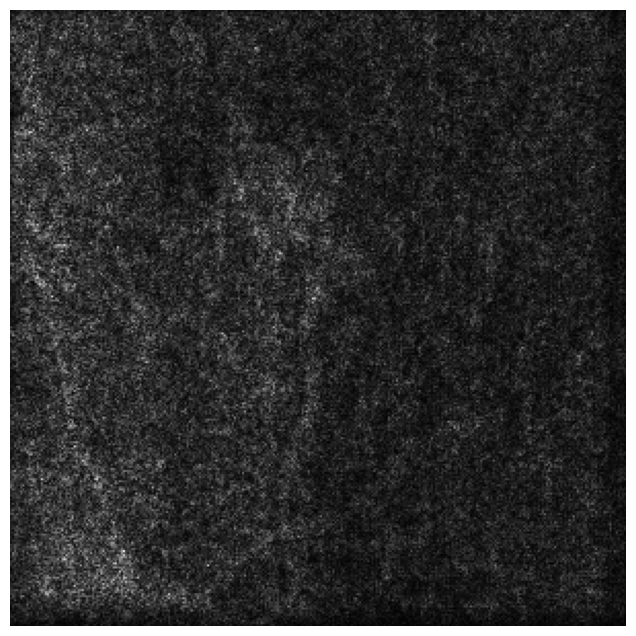

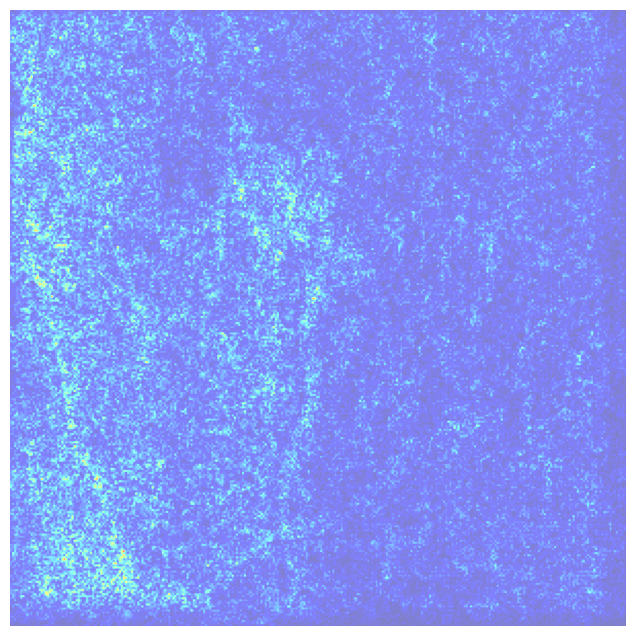

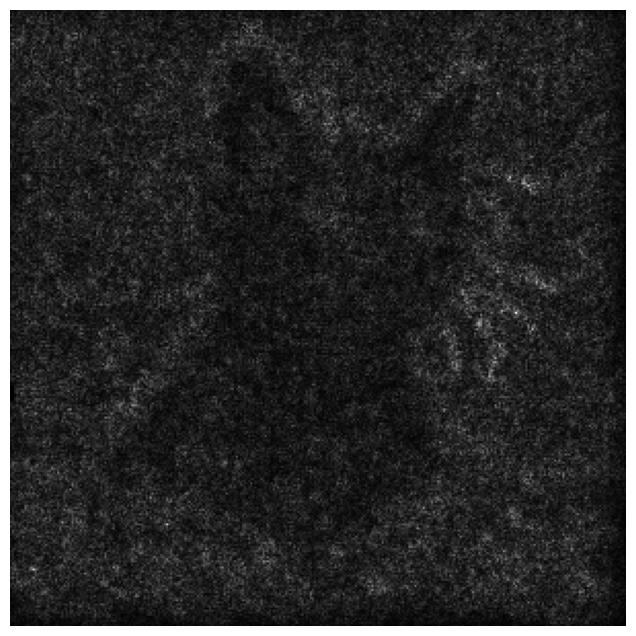

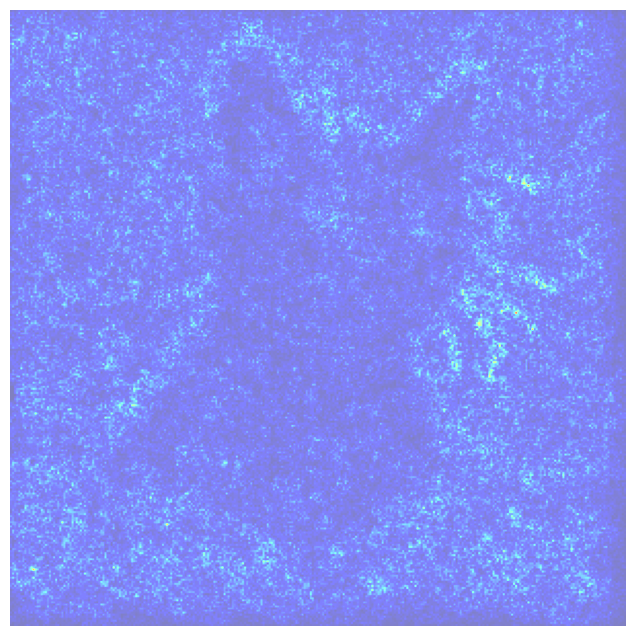

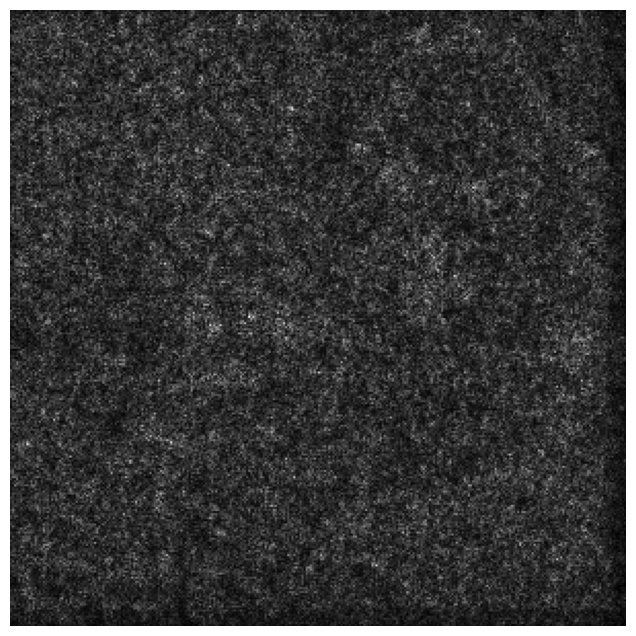

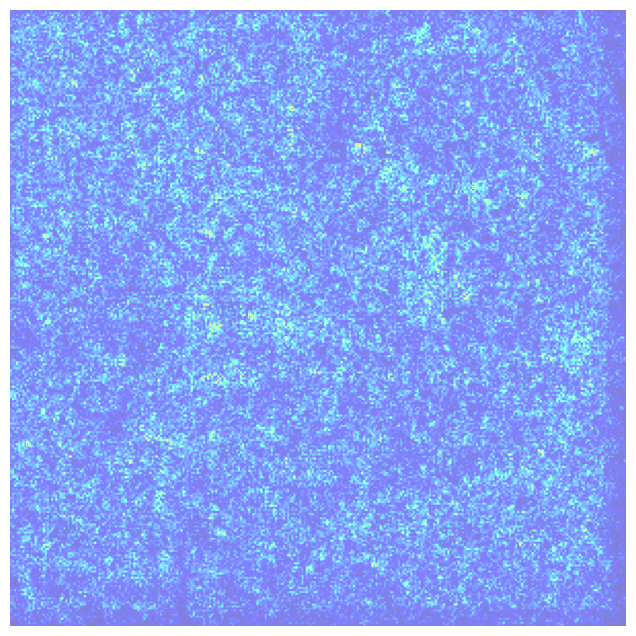

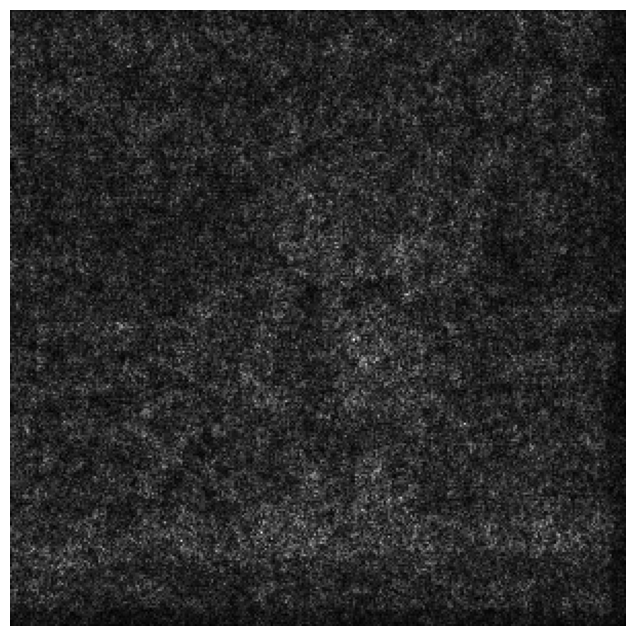

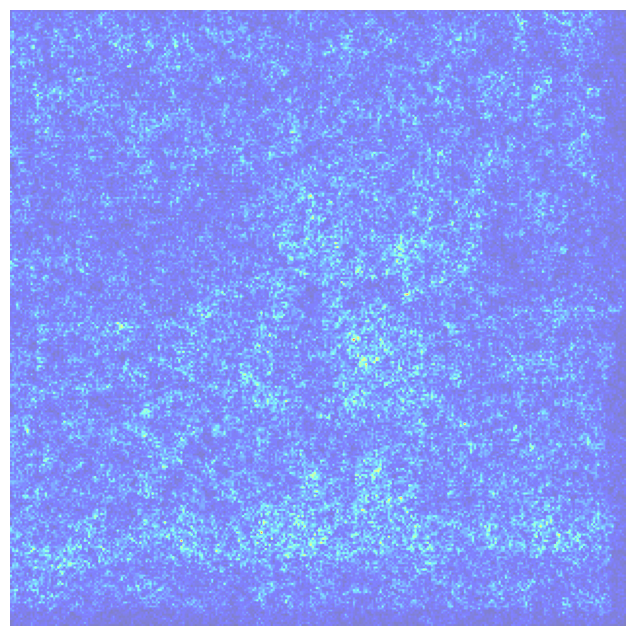

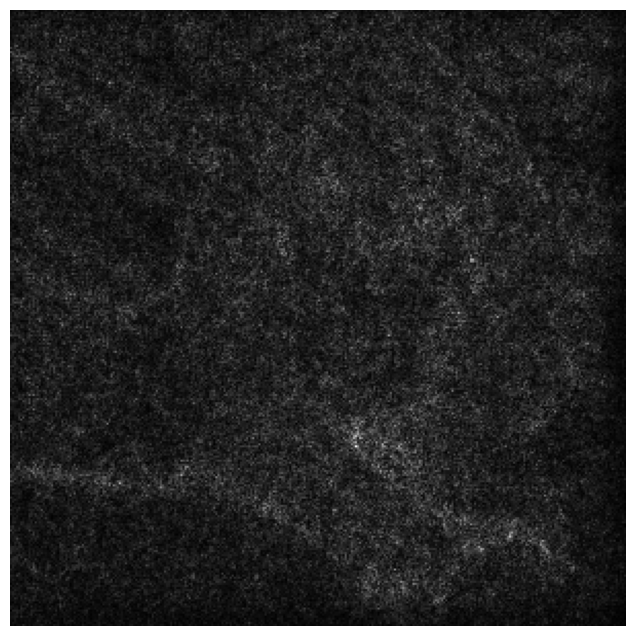

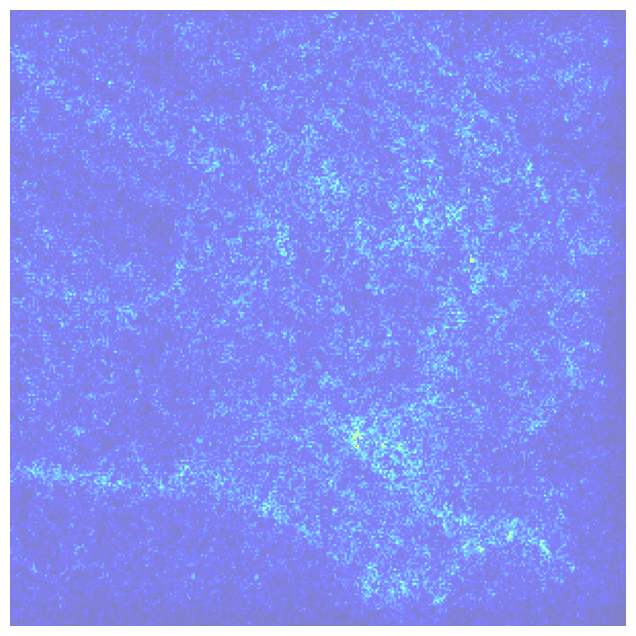

In [9]:
# load initial weights
model.load_weights('0_epochs.h5')

# generate the saliency maps for the 5 test images
# YOUR CODE HERE

# list of image files and corresponding labels
image_label_pairs = [
    ('cat1.jpg', 0),
    ('cat2.jpg', 0),
    ('catanddog.jpg', 0),
    ('dog1.jpg', 1),
    ('dog2.jpg', 1)
]

# loop through and generate saliency maps
for image_file, label in image_label_pairs:
    do_salience(image_file, model, label, prefix='epoch0_salient_')



With untrained weights, you will see something like this in the output.
- You will see strong pixels outside the cat that the model uses that when classifying the image.
- After training that these will slowly start to localize to features inside the pet.

<img src='https://drive.google.com/uc?export=view&id=1h5wP52lwbBUMVLlsgyb-tQl_I9eu42X7' alt='saliency'>


### Configure the model for training

Use `model.compile()` to define the loss, metrics and optimizer.

* Choose a loss function for the model to use when training.
  - For `model.compile()` the ground truth labels from the training set are passed to the model as **integers** (i.e. 0 or 1) as opposed to one-hot encoded vectors.
  - The model predictions are class probabilities.
  - You can browse the [tf.keras.losses](https://www.tensorflow.org/api_docs/python/tf/keras/losses) and determine which one is best used for this case.
  - Remember that you can pass the function as a string (e.g. `loss = 'loss_function_a'`).

* For metrics, you can measure `accuracy`.
* For the optimizer, please use [RMSProp](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop).
  - Please use the default learning rate of `0.001`.

In [10]:
# YOUR CODE HERE
model.compile(
    loss='sparse_categorical_crossentropy',  # handles integer labels + softmax outputs
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),  # RMSProp with default LR
    metrics=['accuracy']  # track accuracy
)


### Train your model

Please pass in the training batches and train your model for just **3** epochs.
- **Note:** Please do not exceed 3 epochs because the grader will expect 3 epochs when grading your output.
  - After submitting your zipped folder for grading, feel free to continue training to improve your model.

We have loaded pre-trained weights for 15 epochs so you can get a better output when you visualize the saliency maps.

In [11]:
# load pre-trained weights
model.load_weights('15_epochs.h5')

# train the model for just 3 epochs
# YOUR CODE HERE
history = model.fit(
    training_batches,
    validation_data=val_batches,
    epochs=18
)

Epoch 1/18


I0000 00:00:1753937120.251574      70 service.cc:148] XLA service 0x7aa97800d4c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753937120.252762      70 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753937120.252791      70 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/582 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.7431 - loss: 0.4710

I0000 00:00:1753937124.384914      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 65ms/step - accuracy: 0.7932 - loss: 0.4594 - val_accuracy: 0.8409 - val_loss: 0.3906
Epoch 2/18
582/582 ━━━━━━━━━━━━━━━━━━━━ 34s 59ms/step - accuracy: 0.8015 - loss: 0.4407 - val_accuracy: 0.8396 - val_loss: 0.3829
Epoch 3/18
582/582 ━━━━━━━━━━━━━━━━━━━━ 35s 61ms/step - accuracy: 0.8076 - loss: 0.4310 - val_accuracy: 0.8444 - val_loss: 0.3740
Epoch 4/18
582/582 ━━━━━━━━━━━━━━━━━━━━ 36s 61ms/step - accuracy: 0.8128 - loss: 0.4214 - val_accuracy: 0.8491 - val_loss: 0.3648
Epoch 5/18
582/582 ━━━━━━━━━━━━━━━━━━━━ 35s 61ms/step - accuracy: 0.8192 - loss: 0.4123 - val_accuracy: 0.8500 - val_loss: 0.3596
Epoch 6/18
582/582 ━━━━━━━━━━━━━━━━━━━━ 35s 61ms/step - accuracy: 0.8219 - loss: 0.4063 - val_accuracy: 0.8538 - val_loss: 0.3555
Epoch 7/18
582/582 ━━━━━━━━━━━━━━━━━━━━ 35s 61ms/step - accuracy: 0.8256 - loss: 0.3951 - val_accuracy: 0.8581 - val_loss: 0.3510
Epoch 8/18
582/582 ━━━━━━━━━━━━━━━━━━━━ 35s 61ms/step - accuracy: 0.8283 - loss: 0.3907 - val_accurac

### Generate saliency maps at 18 epochs

You will now use your `do_salience()` function again on the same test images. Please use the same parameters as before but this time, use the prefix `salient`.

In [12]:
model.save_weights('/kaggle/working/18_epochs.weights.h5')


In [13]:
model.load_weights('/kaggle/working/18_epochs.weights.h5')


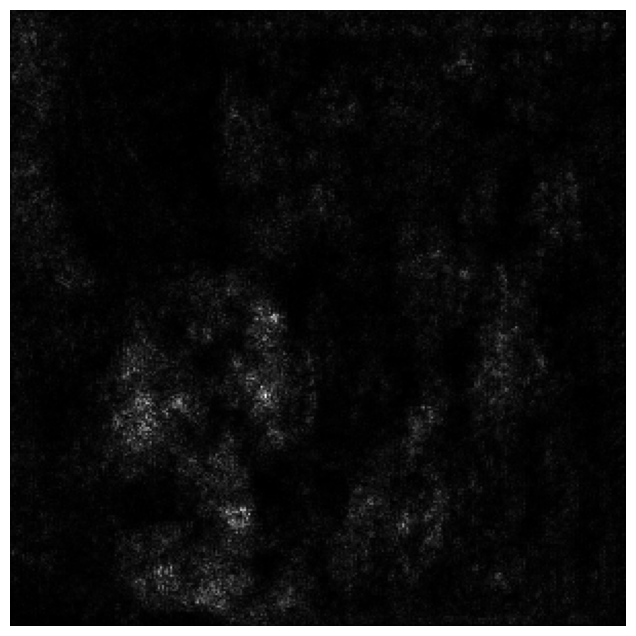

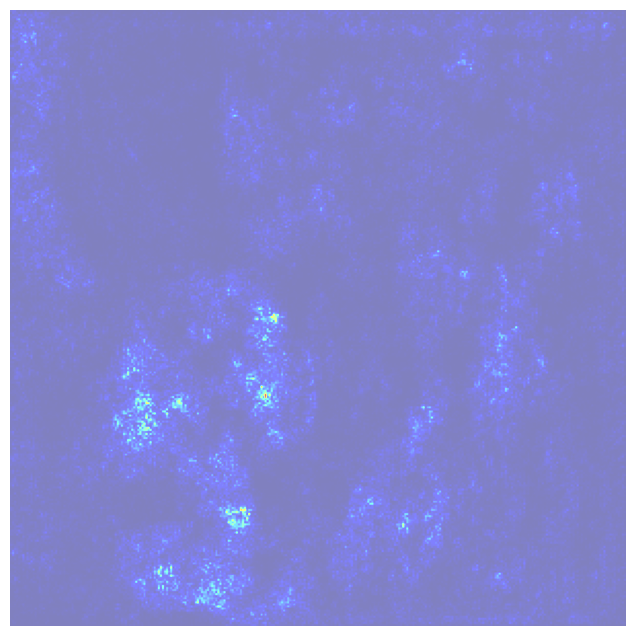

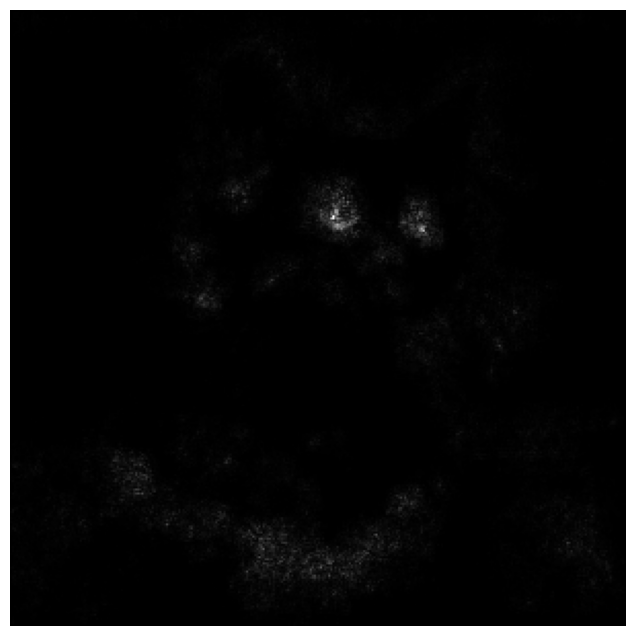

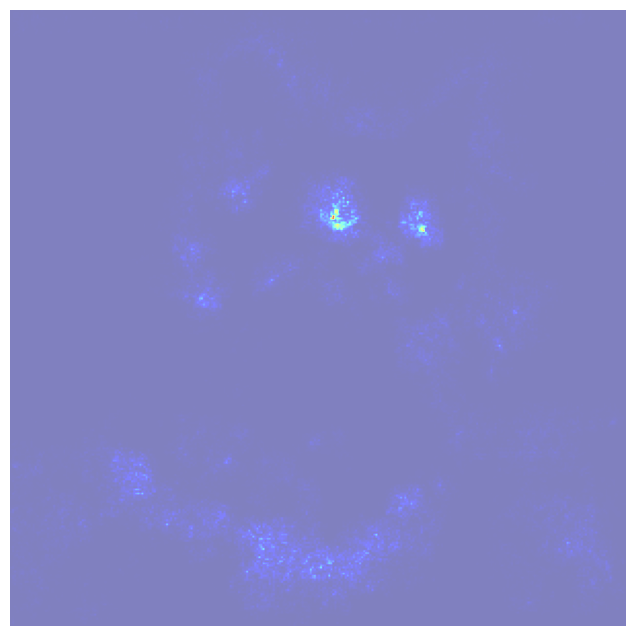

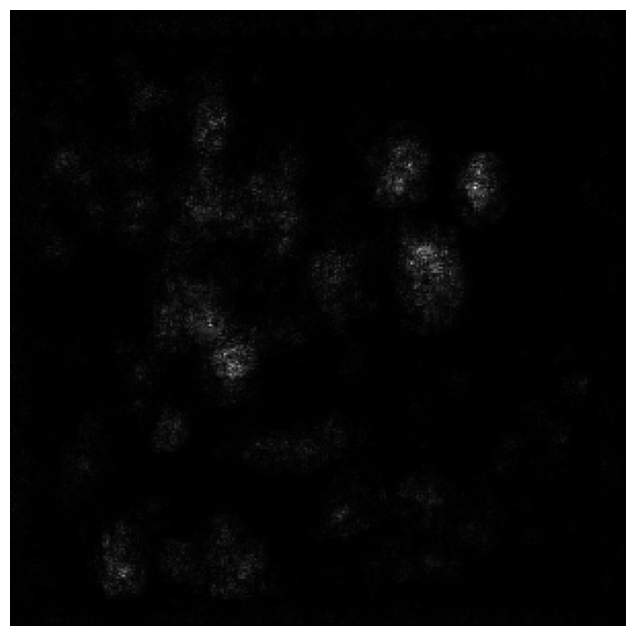

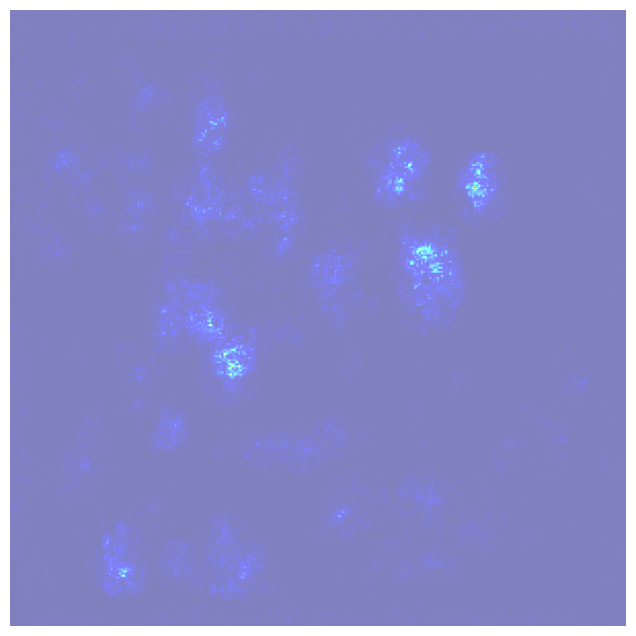

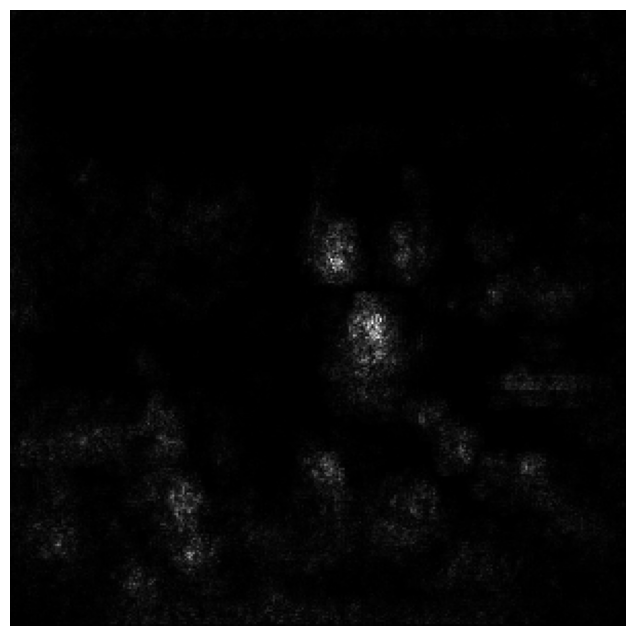

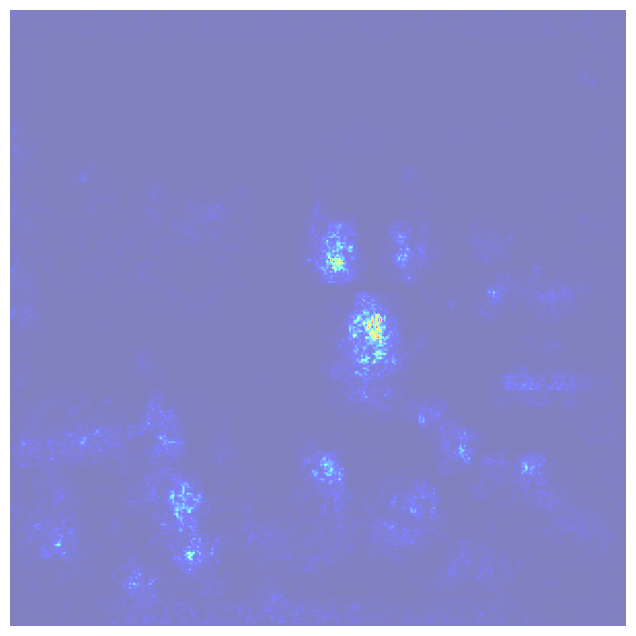

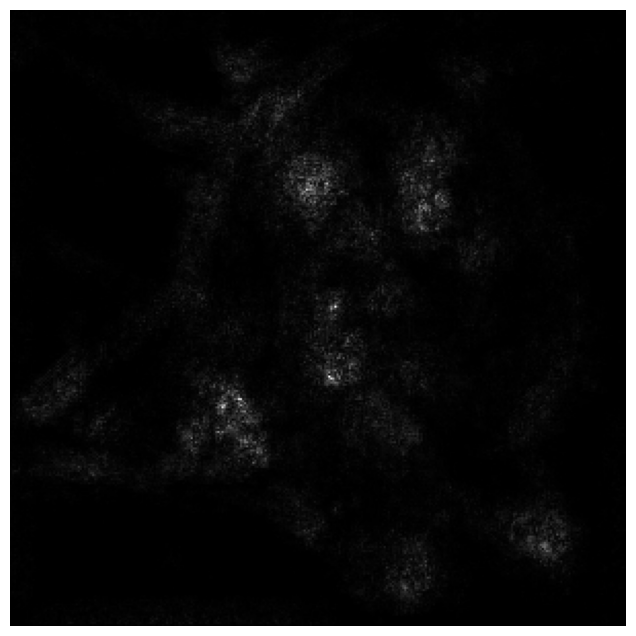

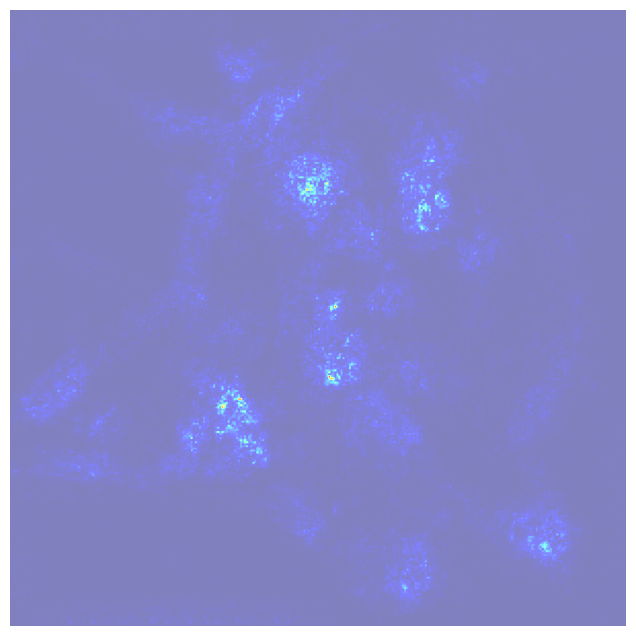

In [14]:
# YOUR CODE HERE

# Generate saliency maps using your existing do_salience function
# Use same parameters as before, just change the prefix

do_salience('cat1.jpg', model, 0, "salient")
do_salience('cat2.jpg', model, 0, "salient")
do_salience('catanddog.jpg', model, 0, "salient")
do_salience('dog1.jpg', model, 1, "salient")
do_salience('dog2.jpg', model, 1, "salient")

You should see that the strong pixels are now very less than the ones you generated earlier. Moreover, most of them are now found on features within the pet.

### Zip the images for grading

Please run the cell below to zip the normalized tensor images you generated at 18 epochs. If you get an error, please check that you have files named:

* salientcat1.jpg
* salientcat2.jpg
* salientcatanddog.jpg
* salientdog1.jpg
* salientdog2.jpg

Afterwards, please download the **images.zip** from the Files bar on the left.

In [15]:
from zipfile import ZipFile

!rm images.zip

filenames = ['cat1.jpg', 'cat2.jpg', 'catanddog.jpg', 'dog1.jpg', 'dog2.jpg']

# writing files to a zipfile
with ZipFile('images.zip','w') as zip:
  for file in filenames:
    zip.write('salient' + file)

print("images.zip generated!")

rm: cannot remove 'images.zip': No such file or directory
images.zip generated!


### Optional: Saliency Maps at 95 epochs

We have pre-trained weights generated at 95 epochs and you can see the difference between the maps you generated at 18 epochs.

--2025-07-31 04:56:13--  https://docs.google.com/uc?export=download&id=14vFpBJsL_TNQeugX8vUTv8dYZxn__fQY
Resolving docs.google.com (docs.google.com)... 209.85.145.100, 209.85.145.102, 209.85.145.101, ...
Connecting to docs.google.com (docs.google.com)|209.85.145.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=14vFpBJsL_TNQeugX8vUTv8dYZxn__fQY&export=download [following]
--2025-07-31 04:56:13--  https://drive.usercontent.google.com/download?id=14vFpBJsL_TNQeugX8vUTv8dYZxn__fQY&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.202.132, 2607:f8b0:4001:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.202.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414488 (405K) [application/octet-stream]
Saving to: ‘95_epochs.h5’

95_epochs.h5        100%[===================>] 404.77K  --.-KB/s    in 0

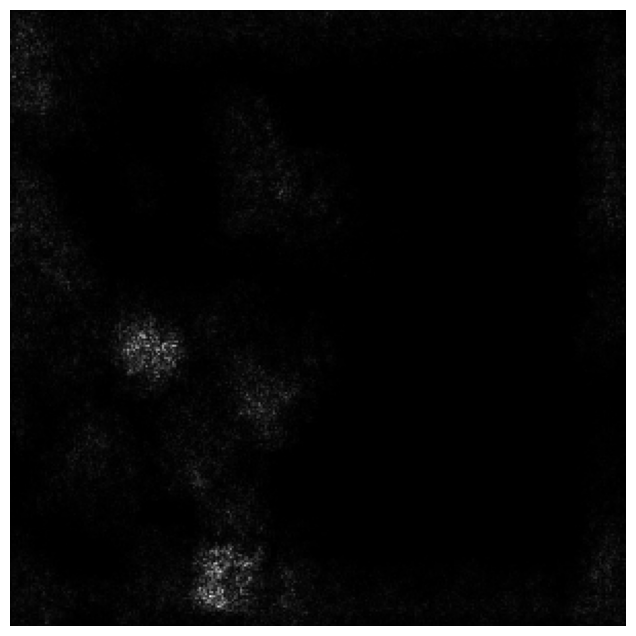

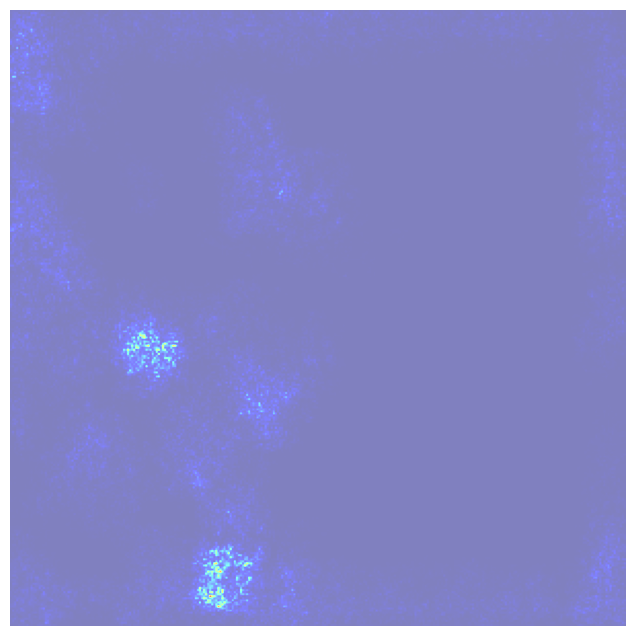

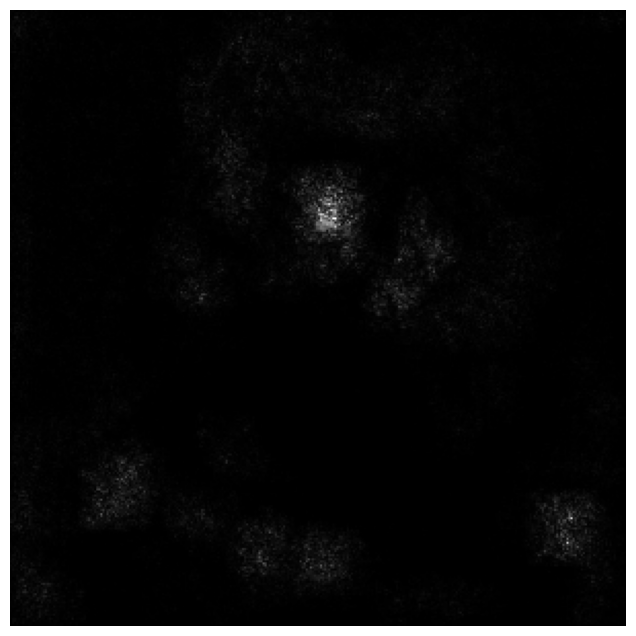

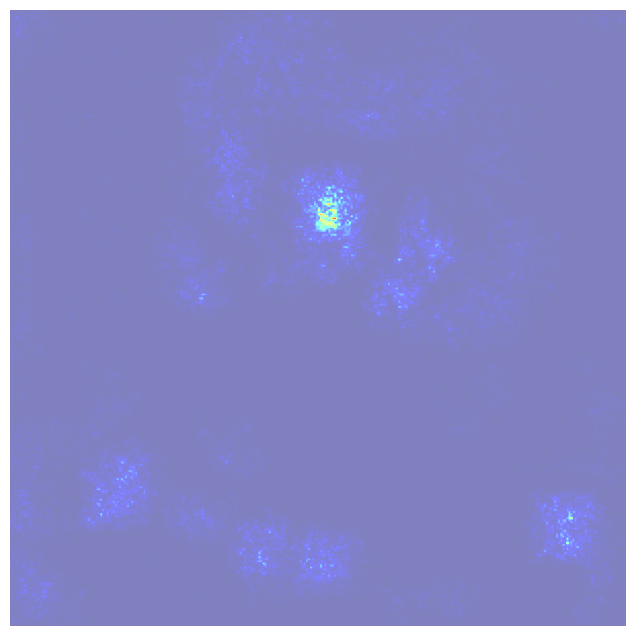

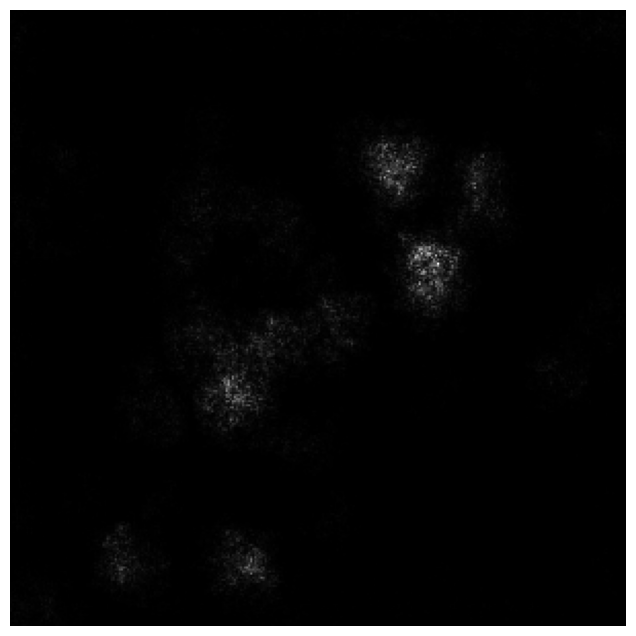

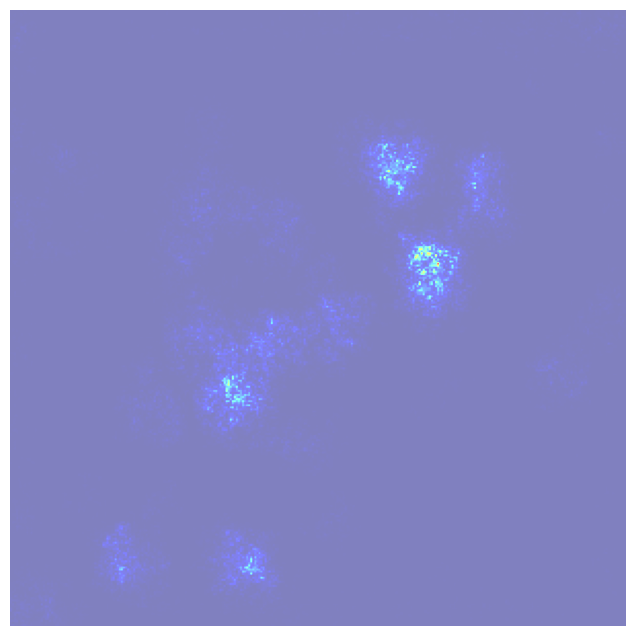

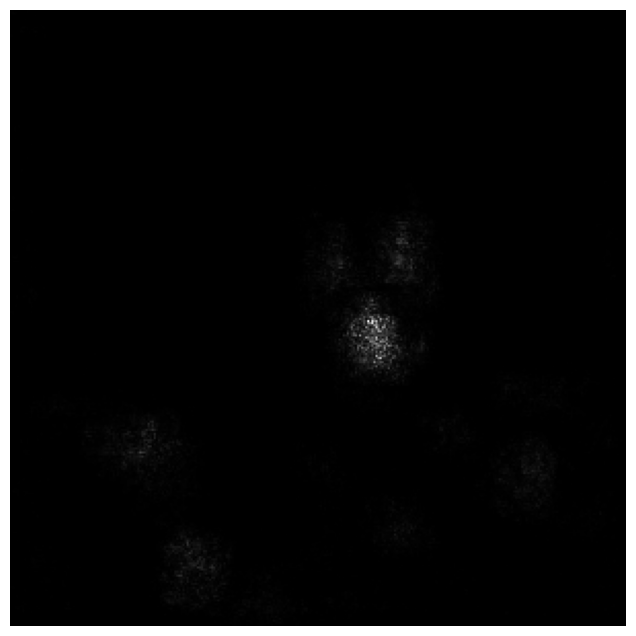

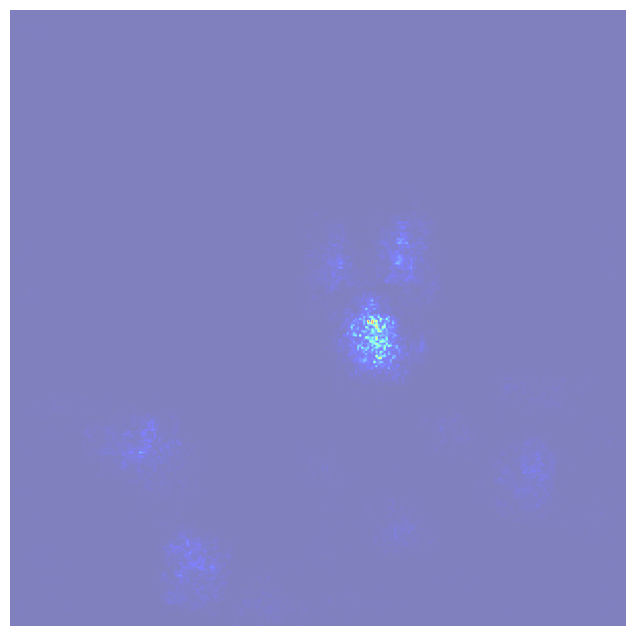

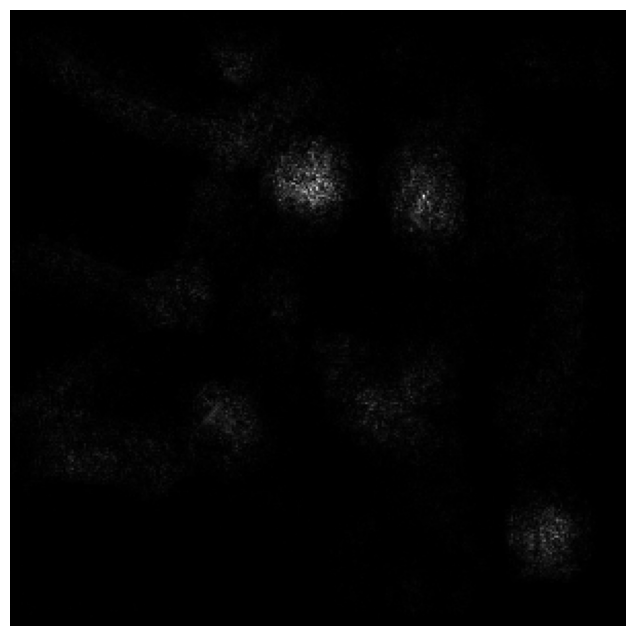

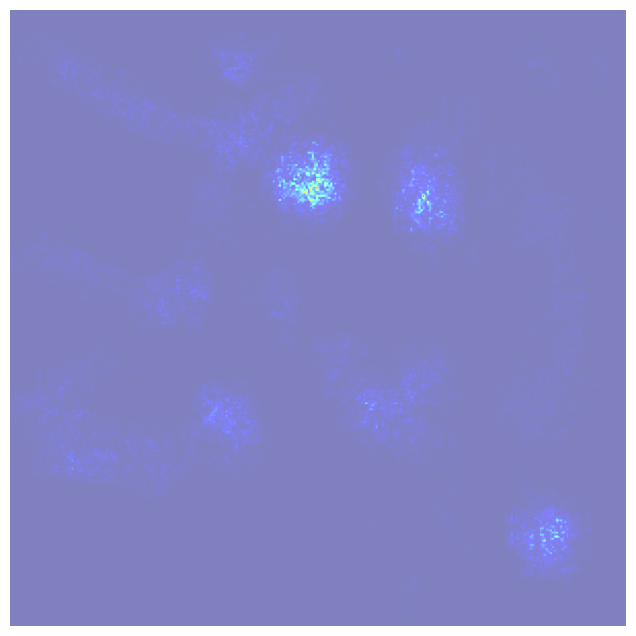

In [16]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=14vFpBJsL_TNQeugX8vUTv8dYZxn__fQY' -O 95_epochs.h5

model.load_weights('95_epochs.h5')

do_salience('cat1.jpg', model, 0, "epoch95_salient")
do_salience('cat2.jpg', model, 0, "epoch95_salient")
do_salience('catanddog.jpg', model, 0, "epoch95_salient")
do_salience('dog1.jpg', model, 1, "epoch95_salient")
do_salience('dog2.jpg', model, 1, "epoch95_salient")

**Congratulations on completing this week's assignment! Please go back to the Coursera classroom and upload the zipped folder to be graded.**